In [72]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import numpy as np
import glob
import os

In [73]:
resources_path = 'resources/'

year_files = glob.glob(os.path.join(resources_path + "year/", '*.csv'))
cpi_file = glob.glob(os.path.join(resources_path + "cpi/", '*.csv'))
all_file = glob.glob(os.path.join(resources_path, '*.csv'))
population_file = glob.glob(os.path.join(resources_path + "population/", '*.csv'))

year_data = pd.concat([pd.read_csv(file) for file in year_files], ignore_index=True)
cpi_data = pd.concat([pd.read_csv(file) for file in cpi_file], ignore_index=True)
all_data = pd.concat([pd.read_csv(file) for file in all_file], ignore_index=True)
population_data = pd.concat([pd.read_csv(file) for file in population_file], ignore_index=True)

all_data = all_data.groupby('회계연도')['지출금액(조원)'].sum().reset_index()

population_data = population_data.drop(population_data.index[0])
population_data = population_data[population_data['행정구역별(1)'] == '전국']
population_data = population_data.melt(id_vars=['행정구역별(1)'], var_name='연도', value_name='인구수')
population_data['연도'] = population_data['연도'].str.slice(0, 4).astype(int)
grouped = population_data.groupby('연도')['인구수'].apply(list).reset_index()

# Extract the first and second population values for each year
grouped['비율'] = grouped['인구수'].apply(lambda x: x[0] if len(x) > 0 else None).astype(float)
grouped['고령자 수'] = grouped['인구수'].apply(lambda x: x[1] if len(x) > 1 else None).astype(int)
population_data = pd.merge(population_data, grouped[['연도', '비율', '고령자 수']], on='연도', how='left')
population_data = population_data.drop_duplicates(subset='연도').sort_values(by='연도').reset_index(drop=True)

# Transpose the DataFrame and set the first row as the index
cpi_data = cpi_data.transpose()
cpi_data.columns = cpi_data.iloc[0]
cpi_data = cpi_data.drop(cpi_data.index[0]) # Drop the first row
cpi_data = cpi_data.reset_index()
cpi_data.columns = ['회계연도', '값']
cpi_data['회계연도'] = cpi_data['회계연도'].astype(int)

# cpi_data = cpi_data.set_index('회계연도')
cpi_data["값"] = (cpi_data["값"] / 100).astype(float)

year_data = year_data[year_data['부문명'] == '노인']
year_data['국회확정금액(천원)'] = year_data['국회확정금액(천원)'].str.replace(',', '').astype(float) 
raw_data = year_data.copy()

year_data['국회확정금액(조원)'] = year_data['국회확정금액(천원)'] / 10_0000_0000
year_data = year_data.drop_duplicates().groupby('회계연도')['국회확정금액(조원)'].sum().reset_index()
year_data = pd.merge(year_data, cpi_data[['회계연도', '값']], on='회계연도')
year_data['실질국회확정금액(조원)'] = (year_data['국회확정금액(조원)'] / year_data['값']).astype(float)

elder_counts = population_data[population_data['연도'] >= 2019]['고령자 수'].reset_index(drop=True)
year_data['인당실질예산(만원)'] = year_data['실질국회확정금액(조원)'] * 1_0000_0000 / elder_counts


In [74]:
# Update this path to the location of your Hangul-supporting font
font_path = os.path.join('resources/font/D2Coding-Ver1.3.2-20180524-ligature.ttf')
font_prop = fm.FontProperties(fname=font_path)
plt.rcParams['font.family'] = font_prop.get_name()

def graph(x_set, y_set, title, x_label, y_label):
    plt.figure(figsize=(10, 6))
    bars = plt.bar(x_set, y_set)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, str(round(yval, 2)), ha='center', va='bottom')

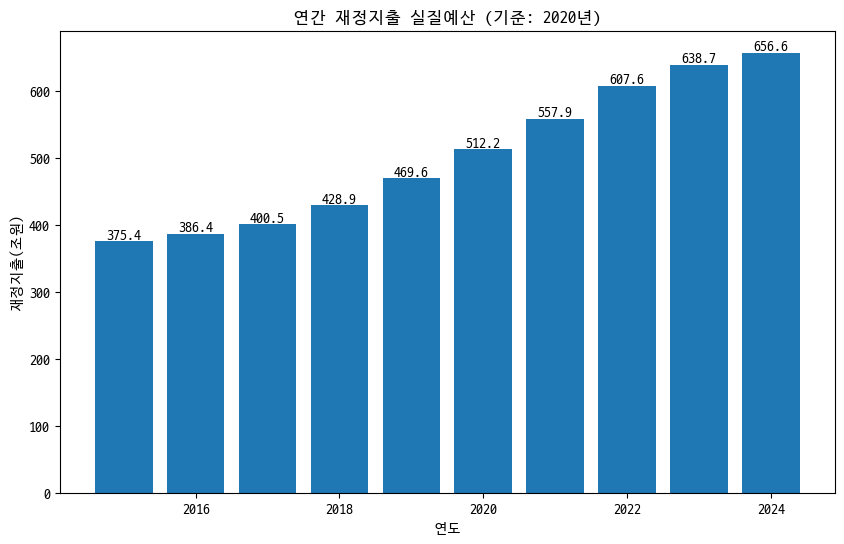

In [75]:
years = all_data['회계연도']
spends = all_data['지출금액(조원)']
graph(years, spends, '연간 재정지출 실질예산 (기준: 2020년)', '연도', '재정지출(조원)')
plt.show()

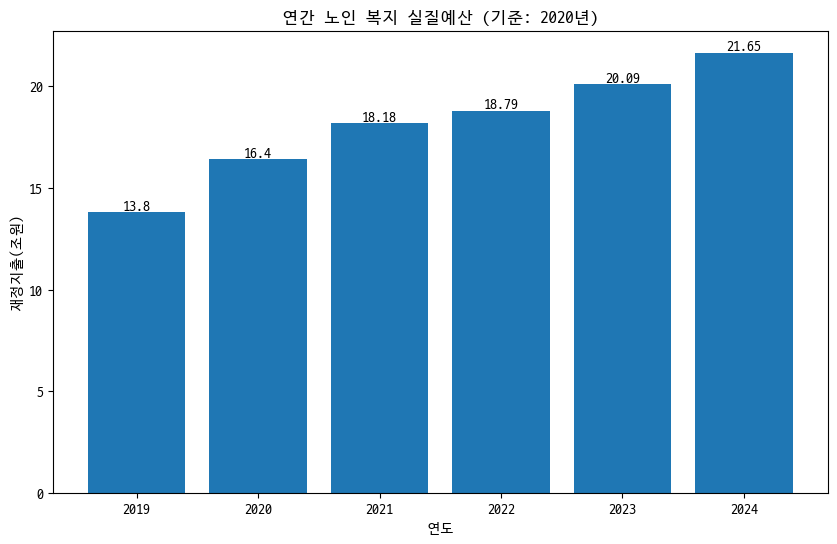

In [76]:
years = year_data['회계연도']
values = year_data['실질국회확정금액(조원)']
graph(years, values, '연간 노인 복지 실질예산 (기준: 2020년)', '연도', '재정지출(조원)')
plt.show()

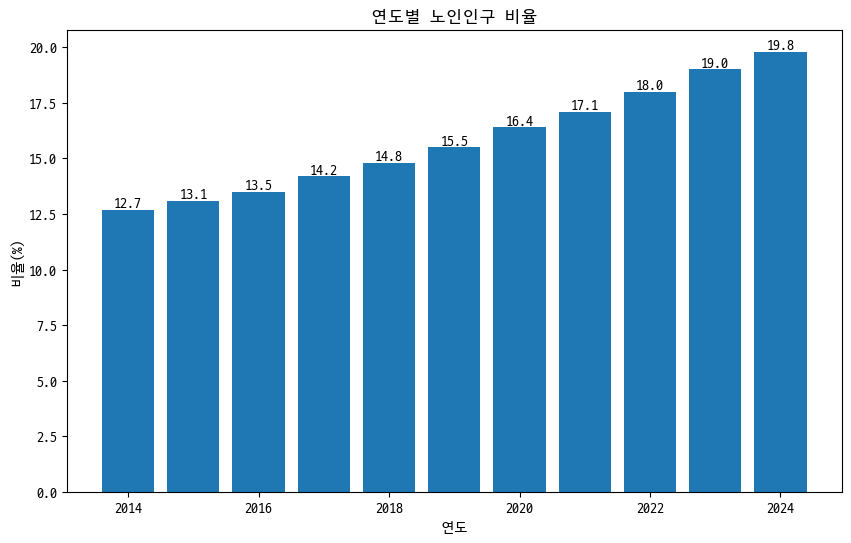

In [77]:
years = population_data['연도']
proportions = population_data['비율']
populations =  population_data['고령자 수']
graph(years, proportions, '연도별 노인인구 비율', '연도', '비율(%)')
plt.show()

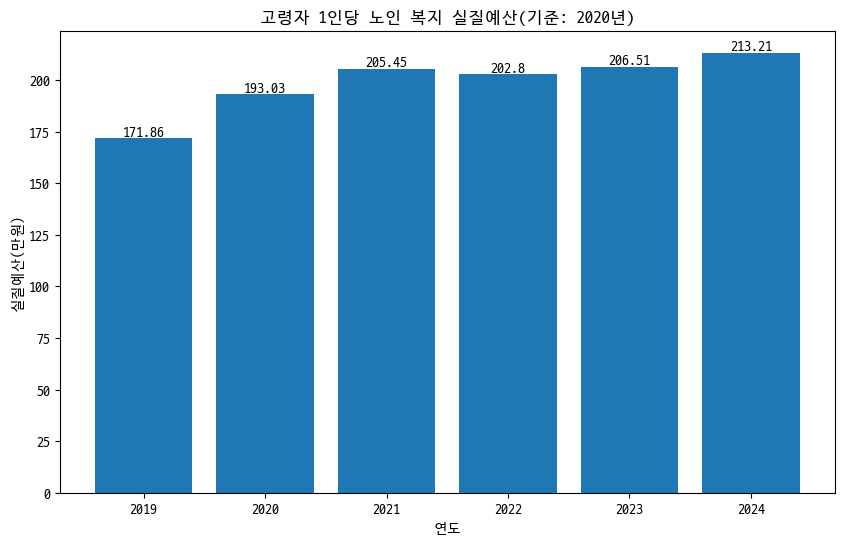

In [78]:
years = year_data['회계연도']
spend_per_capita = year_data['인당실질예산(만원)']
graph(years, spend_per_capita, '고령자 1인당 노인 복지 실질예산(기준: 2020년)', '연도', '실질예산(만원)')
plt.show()

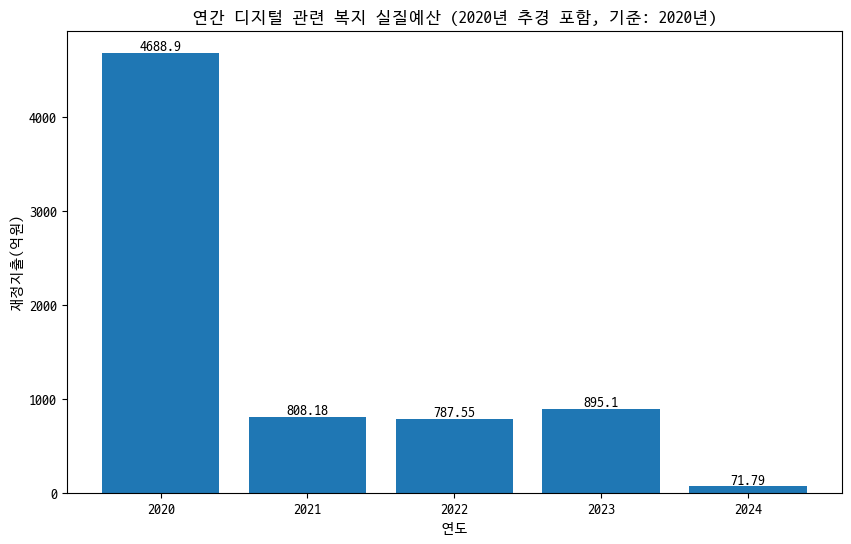

In [79]:
years = pd.DataFrame({'연도': [2020, 2021, 2022, 2023, 2024]})
spends = pd.DataFrame({'재정지출(억원)': [4688.9, 808.18, 787.55, 895.1, 71.79]})
graph(years['연도'], spends['재정지출(억원)'], '연간 디지털 관련 복지 실질예산 (2020년 추경 포함, 기준: 2020년)', '연도', '재정지출(억원)')
plt.show()

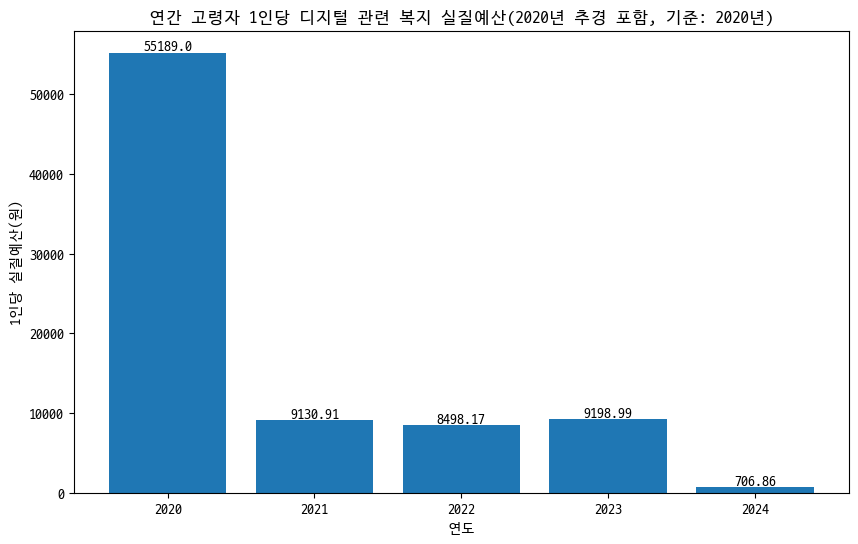

In [80]:
spends_per_capita = (spends['재정지출(억원)'] * 1_0000_0000) / population_data[population_data['연도'] >= 2020]['고령자 수'].reset_index(drop=True)
graph(years['연도'], spends_per_capita, '연간 고령자 1인당 디지털 관련 복지 실질예산(2020년 추경 포함, 기준: 2020년)', '연도', '1인당 실질예산(원)')
plt.show()

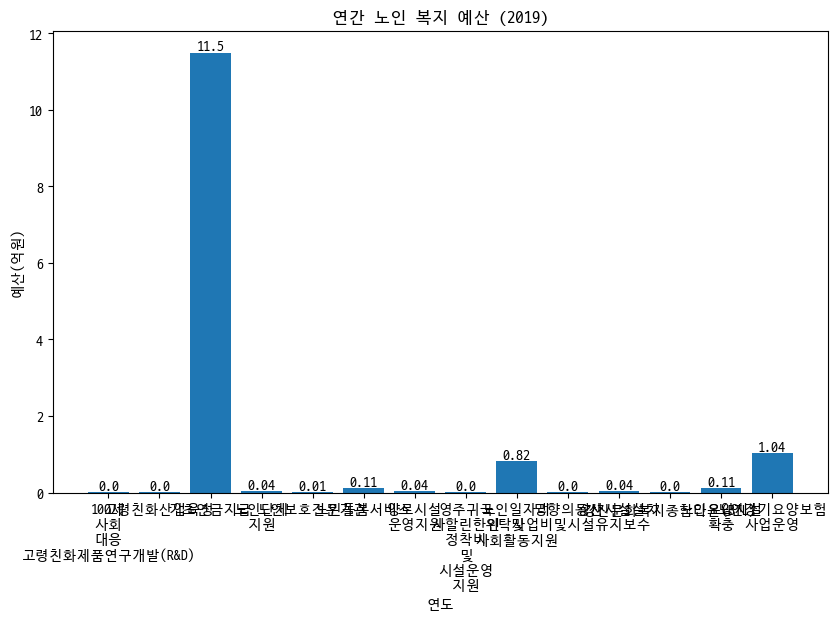

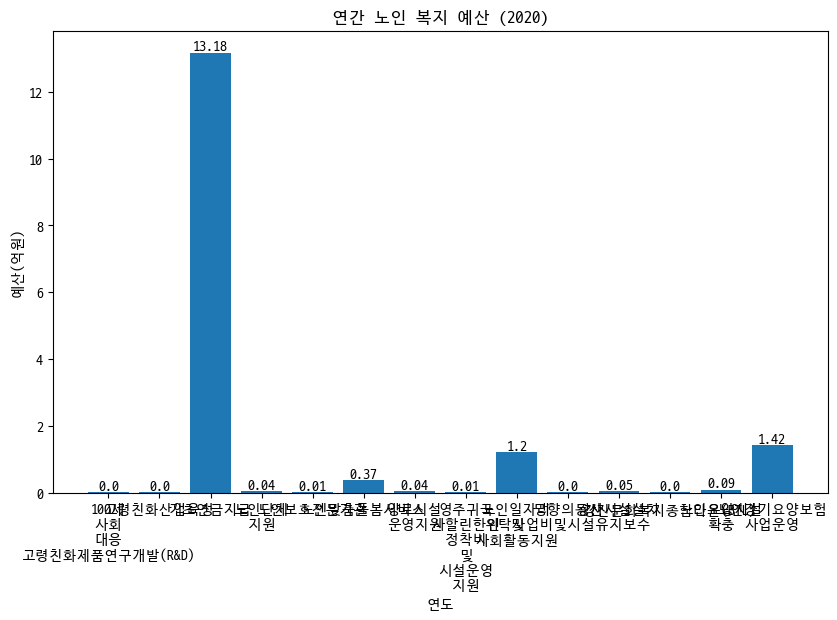

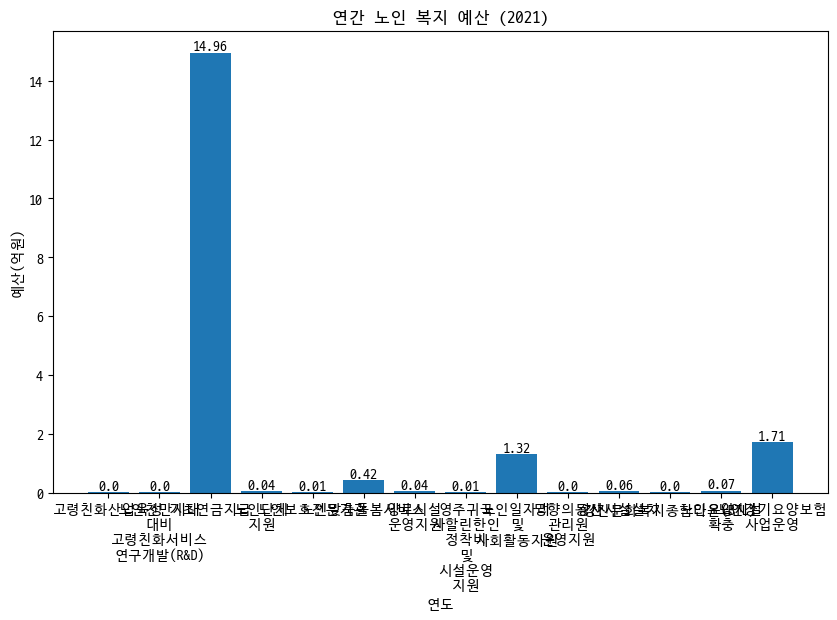

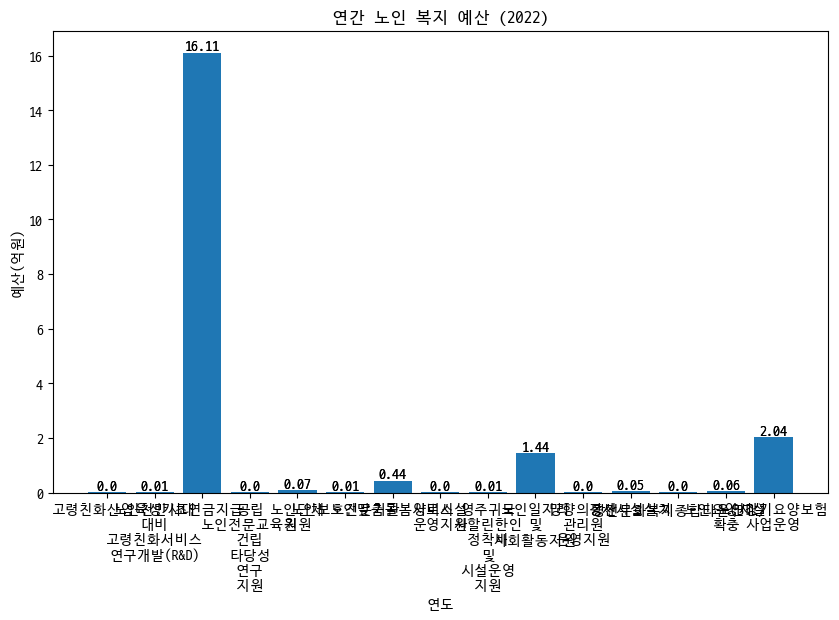

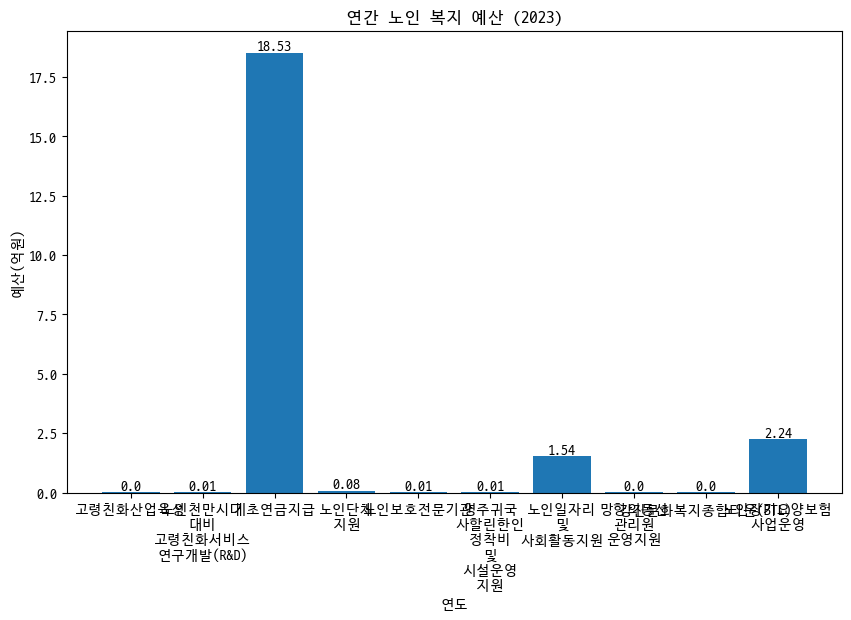

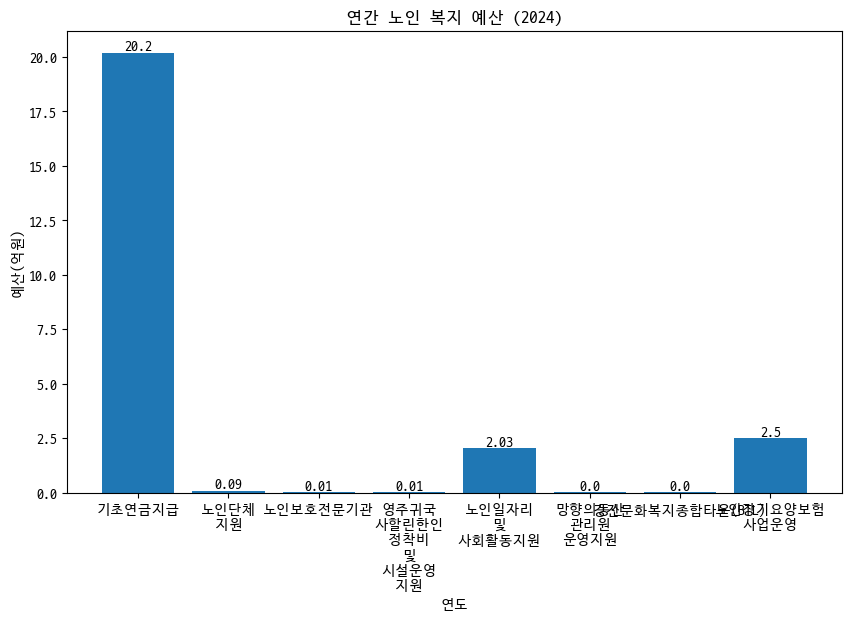

In [84]:
years = raw_data['회계연도'].drop_duplicates().sort_values()
raw_data['세부사업명'] = raw_data['세부사업명'].str.replace(' ', '\n')
for year in years:
    year_specific_data = raw_data[raw_data['회계연도'] == year]
    graph(year_specific_data['세부사업명'], year_specific_data['국회확정금액(천원)'] / 10_0000_0000, '연간 노인 복지 예산 (' + str(year) + ')', '연도', '예산(억원)')
    plt.show()